In [3]:
# Imports
import logging
import random
from typing import Iterable, Optional, Sequence, Tuple

import math
import numpy as np
import torch
from reagent.ope.estimators.sequential_estimators import (
    DMEstimator,
    DoublyRobustEstimator,
    EpsilonGreedyRLPolicy,
    IPSEstimator,
    MAGICEstimator,
    NeuralDualDICE,
    RandomRLPolicy,
    RewardProbability,
    RLEstimatorInput,
    State,
    StateDistribution,
    StateReward,
    ValueFunction,
)
from reagent.ope.estimators.types import Action, ActionSpace
from reagent.ope.test.envs import Environment, PolicyLogGenerator
from reagent.ope.trainers.rl_tabular_trainers import (
    DPTrainer,
    DPValueFunction,
    TabularPolicy,
)
from reagent.ope.test.gridworld import *

import matplotlib
import matplotlib.pyplot as plt

## Configurations

Alter gamma to affect the discount on the reward. 

In [4]:
GAMMA = 0.9

## Evaluate Estimators on a Policy

Given a dataset of trajectories (episodes) generated by some logging policy, we evaluate the given target policy using 6 popular offline policy estimators for the sequential setting. 

In [5]:
def evaluate_estimators(log, target_policy, value_fun, ground_truth):
    estimator_input = RLEstimatorInput(
        gamma=GAMMA,
        log=log,
        target_policy=target_policy,
        value_function=value_func,
        ground_truth=ground_truth,
    )
    
    dice_results = NeuralDualDICE(state_dim=2, 
                                  action_dim=4, 
                                  deterministic_env=True,
                                  batch_size=512, 
                                  training_samples=10000, 
                                  value_lr = 0.001, 
                                  zeta_lr = 0.0001, 
                                  device=device).evaluate(estimator_input)

    dm_results = DMEstimator(device=device).evaluate(estimator_input)

    ips_results = IPSEstimator(weight_clamper=None, weighted=False, device=device).evaluate(
        estimator_input
    )
    ips_results_weighted = IPSEstimator(weight_clamper=None, weighted=True, device=device).evaluate(
        estimator_input
    )
    dr_results = DoublyRobustEstimator(weight_clamper=None, weighted=False, device=device).evaluate(
        estimator_input
    )
    dr_results_weighted = DoublyRobustEstimator(weight_clamper=None, weighted=True, device=device).evaluate(
        estimator_input
    )

    magic_results = MAGICEstimator(device=device).evaluate(
        estimator_input, num_resamples=10, loss_threhold=0.0000001, lr=0.00001
    )
    
    return {"dm": dm_results,
            "ips": ips_results,
            "ips_weighted": ips_results_weighted,
            "dr": dr_results,
            "dr_weighted": dr_results_weighted,
            "magic": magic_results,
            "dice": dice_results}

## Generate Trajectories, Policies, and Evaluate Estimators

We can see that the IPS estimators see good performance for smaller numbers of episodes, but as the number of episodes increases, we see worsening in performance which makes sense as the variance factor is likely increasing. 

In [6]:
random.seed(1234)
np.random.seed(1234)
torch.random.manual_seed(1234)

logging.basicConfig(level=logging.WARNING)

device = torch.device("cuda") if torch.cuda.is_available() else None
print(f"device - {device}")

gridworld = GridWorld.from_grid(
    [
        ["s", "0", "0", "0", "0"],
        ["0", "0", "0", "W", "0"],
        ["0", "0", "0", "0", "0"],
        ["0", "W", "0", "0", "0"],
        ["0", "0", "0", "0", "g"],
    ],
    max_horizon=1000,
)
print(f"GridWorld:\n{gridworld}")

action_space = ActionSpace(4)
opt_policy = TabularPolicy(action_space)
trainer = DPTrainer(gridworld, opt_policy)
value_func = trainer.train(gamma=GAMMA)

print(f"Opt Policy:\n{gridworld.dump_policy(opt_policy)}")
print(f"Opt state values:\n{gridworld.dump_value_func(value_func)}")

behavivor_policy = RandomRLPolicy(action_space)
target_policy = EpsilonGreedyRLPolicy(opt_policy, 0.3)
model = NoiseGridWorldModel(gridworld, action_space, epsilon=0.3, max_horizon=1000)
value_func = DPValueFunction(target_policy, model, GAMMA)
ground_truth = DPValueFunction(target_policy, gridworld, GAMMA)

print(
    f"Target Policy ground truth values:\n"
    f"{gridworld.dump_value_func(ground_truth)}"
)

log_generator = PolicyLogGenerator(gridworld, behavivor_policy)

device - None
GridWorld:
⭕⬜⬜⬜
⬜⬜⬜⬜
⬜⬜⬜⬜
⬜⬜⬜⭐

Opt Policy:
⬨⇨⇨⇩
⇩⇩⇨⇩
⇩⇩⇩⇩
⇨⇨⇨⬧

Opt state values:
  3.27  4.74  6.38   8.2
  3.12  4.58   8.2   8.0
  4.58   6.2   8.0  10.0
   6.2   8.0  10.0   0.0

Target Policy ground truth values:
 0.299  1.52  3.17  5.86
  0.71  1.62  5.43  5.96
  2.48  3.98  5.93  9.17
  4.35  6.37  9.04   0.0



In [ ]:
result_maps = {}
xs = []
lengths = [5, 10, 100, 400]
# Now evaluate the estimators as the number of episodes increases
try:
    for length in lengths:
        small_log = []
        for state in random.sample(list(gridworld.states), 5):
            small_log.extend([log_generator.generate_log(state, length) for _ in range(50)])
        print(f"Evaluating estimators on {length}-length episodes")
        results = evaluate_estimators(small_log, target_policy, value_func, ground_truth)
        for name, result in results.items():
            if not name in result_maps:
                result_maps[name] = []
            res = result.report()[3].rmse.cpu().numpy()
            result_maps[name].append(res)
        xs.append(ep)
except KeyboardInterrupt:
    pass
        
fig, ax = plt.subplots()
for name, results in result_maps.items():
    ax.plot(xs, results, label=name)

# Log scale vastly improves visualization
plt.yscale("log")
plt.xscale("log")
plt.legend(loc='best')
plt.show()

Evaluating estimators on 5-length episodes


I0812 115834.496 sequential_estimators.py:742] Data loading time: 12.767301744000001
I0812 115835.276 sequential_estimators.py:786] Samples 0, Avg Zeta Loss -0.0024972213432192802, Avg Value Loss 0.014194303192198277,
Time per 1000 samples: 16.181496048
I0812 120436.815 sequential_estimators.py:786] Samples 1000, Avg Zeta Loss 1.762339136944153, Avg Value Loss -1.3786156352562846,
Time per 1000 samples: 7850.563727696001
I0812 121012.476 sequential_estimators.py:786] Samples 2000, Avg Zeta Loss 3.8674179503917667, Avg Value Loss -2.7155063413381604,
Time per 1000 samples: 7573.734335957
I0812 121733.886 sequential_estimators.py:786] Samples 3000, Avg Zeta Loss 5.210317928791042, Avg Value Loss -3.3756288778781895,
Time per 1000 samples: 8524.390936679


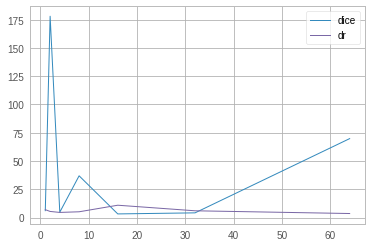

In [7]:
fig, ax = plt.subplots()
for name, results in result_maps.items():
    ax.plot(xs, results, label=name)

# Log scale vastly improves visualization
#plt.yscale("log")
#plt.xscale("log")
plt.legend(loc='best')
plt.show()